In [1]:
import torch
from torch.autograd import Variable as V
import torchvision.models as models
from torchvision import transforms as trn
from torch.nn import functional as F
import os
import numpy as np
from scipy.misc import imresize as imresize
import cv2
from PIL import Image

# th architecture to use
arch = 'resnet18'

# load the pre-trained weights
model_file = 'whole_%s_places365.pth.tar' % arch

features_blobs = []

In [2]:
def load_labels():
    # prepare all the labels
    # scene category relevant
    file_name_category = 'categories_places365.txt'
    if not os.access(file_name_category, os.W_OK):
        synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/categories_places365.txt'
        os.system('wget ' + synset_url)
    classes = list()
    with open(file_name_category) as class_file:
        for line in class_file:
            classes.append(line.strip().split(' ')[0][3:])
    classes = tuple(classes)

    # indoor and outdoor relevant
    file_name_IO = 'IO_places365.txt'
    if not os.access(file_name_IO, os.W_OK):
        synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/IO_places365.txt'
        os.system('wget ' + synset_url)
    with open(file_name_IO) as f:
        lines = f.readlines()
        labels_IO = []
        for line in lines:
            items = line.rstrip().split()
            labels_IO.append(int(items[-1]) -1) # 0 is indoor, 1 is outdoor
    labels_IO = np.array(labels_IO)

    # scene attribute relevant
    file_name_attribute = 'labels_sunattribute.txt'
    if not os.access(file_name_attribute, os.W_OK):
        synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/labels_sunattribute.txt'
        os.system('wget ' + synset_url)
    with open(file_name_attribute) as f:
        lines = f.readlines()
        labels_attribute = [item.rstrip() for item in lines]
    file_name_W = 'W_sceneattribute_wideresnet18.npy'
    if not os.access(file_name_W, os.W_OK):
        synset_url = 'http://places2.csail.mit.edu/models_places365/W_sceneattribute_wideresnet18.npy'
        os.system('wget ' + synset_url)
    W_attribute = np.load(file_name_W)

    return classes, labels_IO, labels_attribute, W_attribute

def hook_feature(module, input, output):
    features_blobs.append(np.squeeze(output.data.cpu().numpy()))

def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[class_idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(imresize(cam_img, size_upsample))
    return output_cam

def returnTF():
# load the image transformer
    tf = trn.Compose([
        trn.Scale((224,224)), # Redimensiona a imagem / Interpolação Bilinear (https://www.cambridgeincolour.com/tutorials/image-interpolation.htm) 
        trn.ToTensor(), # Tensor = Array N-Dimensional no PyTorch
        trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return tf


def load_model():
    # this model has a last conv feature map as 14x14

    model_file = 'whole_resnet18_places365_python36.pth.tar'
    if not os.access(model_file, os.W_OK):
        os.system('wget http://places2.csail.mit.edu/models_places365/' + model_file)
        os.system('wget https://raw.githubusercontent.com/csailvision/places365/master/wideresnet.py')
    useGPU = 0
    if useGPU == 1:
        model = torch.load(model_file)
    else:
        model = torch.load(model_file, map_location=lambda storage, loc: storage) # allow cpu

    # the following is deprecated, everything is migrated to python36

    ## if you encounter the UnicodeDecodeError when use python3 to load the model, add the following line will fix it. Thanks to @soravux
    #from functools import partial
    #import pickle
    #pickle.load = partial(pickle.load, encoding="latin1")
    #pickle.Unpickler = partial(pickle.Unpickler, encoding="latin1")
    #model = torch.load(model_file, map_location=lambda storage, loc: storage, pickle_module=pickle)

    model.eval()
    # hook the feature extractor
    features_names = ['layer4','avgpool'] # this is the last conv layer of the resnet
    for name in features_names:
        model._modules.get(name).register_forward_hook(hook_feature)
    return model

In [3]:
import os
import random
# 129928
# http://www.publicacoesdeturismo.com.br/calculoamostral/ # 384
imagens = os.listdir('Imagens')
random.seed(123)
amostra = random.sample(imagens, 384)
amostra

['01331989000189_90.jpg',
 '02168943000153_90.jpg',
 '09168804000179_0.jpg',
 '02623259000114_180.jpg',
 '92316124000107_270.jpg',
 '00969340000125_180.jpg',
 '13150147000100_90.jpg',
 '07511666000153_180.jpg',
 '72364490000116_180.jpg',
 '03723572000197_0.jpg',
 '07609899000193_180.jpg',
 '07544735000125_180.jpg',
 '05371711000196_180.jpg',
 '00028986007544_180.jpg',
 '10238217000198_0.jpg',
 '02179173000225_90.jpg',
 '16273641000150_0.jpg',
 '01706877000165_270.jpg',
 '07201112000150_270.jpg',
 '10480822000170_180.jpg',
 '93019644000102_0.jpg',
 '02302100000106_0.jpg',
 '03377824000173_0.jpg',
 '47160221000190_0.jpg',
 '00520304000180_90.jpg',
 '95862744000121_90.jpg',
 '14720688000199_180.jpg',
 '05764366000150_0.jpg',
 '66455593000199_270.jpg',
 '39383880000168_90.jpg',
 '07721203000116_180.jpg',
 '53476057000128_0.jpg',
 '04607201000102_180.jpg',
 '17018410000162_180.jpg',
 '12833061000119_180.jpg',
 '57118929000137_90.jpg',
 '07198293000102_180.jpg',
 '08979527000200_270.jpg',
 '

In [4]:
# load the labels
classes, labels_IO, labels_attribute, W_attribute = load_labels()

# load the model
features_blobs = []
model = load_model()

# load the transformer
tf = returnTF() # image transformer

# get the softmax weight
params = list(model.parameters())
weight_softmax = params[-2].data.numpy()
weight_softmax[weight_softmax<0] = 0

# load the test ima0ge
prefix = 'Imagens/'

for imagem in amostra:
    
    print(imagem)
    
    img_url = prefix + imagem
    
    #os.system('wget %s -q -O test.jpg' % img_url)
    img = Image.open(img_url)
    input_img = V(tf(img).unsqueeze(0), volatile=True)

    # forward pass
    logit = model.forward(input_img)
    h_x = F.softmax(logit).data.squeeze()
    probs, idx = h_x.sort(0, True)

    with open('Resultados.txt', 'w') as f:
                
        f.write('RESULT ON ' + img_url + '\n')
        
        # output the IO prediction
        io_image = np.mean(labels_IO[idx[:10].numpy()]) # vote for the indoor or outdoor
        if io_image < 0.5:
            f.write('--TYPE OF ENVIRONMENT: indoor\n')
        else:
            f.write('--TYPE OF ENVIRONMENT: outdoor\n')

        # output the prediction of scene category
        f.write('--SCENE CATEGORIES:\n')
        for i in range(0, 5):
            f.write('{:.3f} -> {}'.format(probs[i], classes[idx[i]]) + '\n')

        # output the scene attributes
        responses_attribute = W_attribute.dot(features_blobs[1])
        idx_a = np.argsort(responses_attribute)
        f.write('--SCENE ATTRIBUTES:\n')
        f.write(', '.join([labels_attribute[idx_a[i]] for i in range(-1,-10,-1)]) + '\n')

        # generate class activation mapping
        f.write('Class activation map is saved as cam-' + imagem + '\n')
        
    CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0]])

    # render the CAM and output
    img = cv2.imread(img_url)
    height, width, _ = img.shape
    heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
    result = heatmap * 0.4 + img * 0.5
    cv2.imwrite('cam-' + imagem, result)

/usr/lib64/python2.7/site-packages/torch/serialization.py:286: SourceChangeWarning: source code of class 'torchvision.models.resnet.ResNet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/lib64/python2.7/site-packages/torch/serialization.py:255: UnicodeWarning: Unicode unequal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if original_source != current_source:
/usr/lib64/python2.7/site-packages/torch/serialization.py:286: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/lib64/python2.7/site-packages/

01331989000189_90.jpg


/usr/lib/python2.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


02168943000153_90.jpg
09168804000179_0.jpg
02623259000114_180.jpg
92316124000107_270.jpg
00969340000125_180.jpg
13150147000100_90.jpg
07511666000153_180.jpg
72364490000116_180.jpg
03723572000197_0.jpg
07609899000193_180.jpg
07544735000125_180.jpg
05371711000196_180.jpg
00028986007544_180.jpg
10238217000198_0.jpg
02179173000225_90.jpg
16273641000150_0.jpg
01706877000165_270.jpg
07201112000150_270.jpg
10480822000170_180.jpg
93019644000102_0.jpg
02302100000106_0.jpg
03377824000173_0.jpg
47160221000190_0.jpg
00520304000180_90.jpg
95862744000121_90.jpg
14720688000199_180.jpg
05764366000150_0.jpg
66455593000199_270.jpg
39383880000168_90.jpg
07721203000116_180.jpg
53476057000128_0.jpg
04607201000102_180.jpg
17018410000162_180.jpg
12833061000119_180.jpg
57118929000137_90.jpg
07198293000102_180.jpg
08979527000200_270.jpg
39622006000136_270.jpg
12211392000117_0.jpg
21916881000165_90.jpg
18600476000129_90.jpg
20540229000126_180.jpg
87505632000276_0.jpg
11290395000120_270.jpg
20723967000109_0.jpg


16792076000137_270.jpg
39092812000140_180.jpg
74479577000164_180.jpg
72568587000140_270.jpg
05702957000101_180.jpg
09447306000165_90.jpg
26519663000100_270.jpg
08261975000185_0.jpg
17861178000120_270.jpg
70042429000127_0.jpg
82662958000102_270.jpg
16676520000159_180.jpg


In [5]:
print(model)

ResNet (
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU (inplace)
  (maxpool): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential (
    (0): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d

In [6]:
len(features_blobs)

768

In [7]:
features = []
for i,j in zip(range(len(amostra)), range(0, len(features_blobs), 2)):
        features.append({'imagem':amostra[i],'layer4':features_blobs[j],'avgpool':features_blobs[j]})
features

[{'avgpool': array([[[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
           0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
           0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
           0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
          ...,
          [6.8717994e-02, 3.6082357e-02, 2.5208881e-01, ...,
           6.0984290e-01, 0.0000000e+00, 0.0000000e+00],
          [3.2521972e-01, 2.0890766e-01, 2.8630376e-01, ...,
           6.1792850e-01, 0.0000000e+00, 0.0000000e+00],
          [1.1445919e-02, 0.0000000e+00, 0.0000000e+00, ...,
           3.6424541e-01, 4.0646262e-02, 0.0000000e+00]],
  
         [[4.4845772e-01, 6.5004331e-01, 4.5134786e-01, ...,
           0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
          [1.4443233e+00, 1.4282273e+00, 5.6194210e-01, ...,
           0.0000000e+00, 0.0000000e+00, 6.7196265e-02],
          [1.7566788e+00, 

In [8]:
print(type(features[0]['layer4']))
print(len(features[0]['layer4']))
print(len(features[0]['layer4'][0]))
print(len(features[0]['layer4'][0][0]))
print(len(features))

print(type(features[0]['avgpool']))
print(len(features[0]['avgpool']))
print(len(features[0]['avgpool'][0]))
print(len(features[0]['avgpool'][0][0]))
print(len(features))

<type 'numpy.ndarray'>
512
7
7
384
<type 'numpy.ndarray'>
512
7
7
384


In [9]:
import numpy as np

X = np.array([features[i]['layer4'] for i in range(len(features))])

In [10]:
print(len(X))
print(X.shape)

nsamples, nx, ny, nz = X.shape
reshaped_X = X.reshape((nsamples,nx*ny*nz))

384
(384, 512, 7, 7)


In [11]:
from sklearn.cluster import KMeans
kmeans = KMeans(random_state=0).fit(reshaped_X)

In [12]:
print(kmeans.labels_)
#>>> kmeans.predict([[0, 0], [4, 4]])
#array([0, 1], dtype=int32)
#>>> kmeans.cluster_centers_
#array([[ 1.,  2.],
#       [ 4.,  2.]])

[6 2 0 5 4 6 2 7 3 4 3 6 1 4 7 1 3 6 6 7 3 6 6 6 1 5 4 7 5 0 0 5 0 6 4 3 3
 0 4 5 2 5 3 3 4 5 0 4 7 2 3 5 6 4 2 7 1 1 5 4 3 3 2 1 3 7 1 7 4 0 4 5 2 2
 6 1 0 6 3 2 7 3 3 5 6 4 1 1 0 7 4 5 0 4 5 6 4 2 2 3 6 5 2 6 0 1 5 5 4 7 5
 3 7 2 4 2 0 5 7 4 3 3 4 5 3 5 3 1 6 3 4 3 7 6 5 0 2 6 1 2 7 5 3 5 6 4 4 6
 2 4 2 7 2 7 5 5 4 6 4 1 6 2 7 7 7 0 2 4 2 4 2 4 7 1 7 2 5 3 4 0 4 5 3 5 3
 2 4 3 1 7 1 2 6 3 0 3 4 1 6 4 7 3 5 4 4 2 2 7 6 0 4 4 5 2 0 1 1 7 3 4 0 6
 3 6 4 4 2 3 4 3 1 1 5 1 3 5 6 0 3 1 7 6 3 5 7 2 6 5 0 5 7 1 4 7 4 7 7 4 4
 4 3 4 3 7 7 6 0 2 2 5 7 3 6 3 5 5 3 5 2 4 0 5 1 0 2 1 1 1 3 3 5 1 7 5 4 0
 4 7 2 4 6 2 7 2 1 3 5 4 1 2 0 5 6 0 0 4 3 5 1 4 4 7 2 2 7 5 4 4 4 4 5 2 3
 0 0 3 4 4 5 3 0 7 4 0 6 3 4 6 3 6 6 2 7 5 2 2 3 6 6 0 1 3 1 4 5 6 2 4 0 2
 0 4 3 7 3 4 2 4 5 4 3 7 0 3]


In [13]:
import pandas as pd

resultado = pd.DataFrame({'imagem':amostra,'cluster':kmeans.labels_})

In [14]:
resultado

cluster                  imagem
0          6   01331989000189_90.jpg
1          2   02168943000153_90.jpg
2          0    09168804000179_0.jpg
3          5  02623259000114_180.jpg
4          4  92316124000107_270.jpg
5          6  00969340000125_180.jpg
6          2   13150147000100_90.jpg
7          7  07511666000153_180.jpg
8          3  72364490000116_180.jpg
9          4    03723572000197_0.jpg
10         3  07609899000193_180.jpg
11         6  07544735000125_180.jpg
12         1  05371711000196_180.jpg
13         4  00028986007544_180.jpg
14         7    10238217000198_0.jpg
15         1   02179173000225_90.jpg
16         3    16273641000150_0.jpg
17         6  01706877000165_270.jpg
18         6  07201112000150_270.jpg
19         7  10480822000170_180.jpg
20         3    93019644000102_0.jpg
21         6    02302100000106_0.jpg
22         6    03377824000173_0.jpg
23         6    47160221000190_0.jpg
24         1   00520304000180_90.jpg
25         5   95862744000121_90.jpg
26         4  14720688000199_180.jpg
27         7    05764366000150_0.jpg
28         5  66455593000199_270.jpg
29         0   39383880000168_90.jpg
..       ...                     ...
354        2  60869971000102_270.jpg
355        2   60493350000169_90.jpg
356        3  05146214000194_270.jpg
357        6  09646237000119_270.jpg
358        6  20964886000109_180.jpg
359        0   02223572000165_90.jpg
360        1   00253725000191_90.jpg
361        3    07415240000104_0.jpg
362        1   09027695000170_90.jpg
363        4   45363777000159_90.jpg
364        5  59610394000142_270.jpg
365        6  01456782000130_180.jpg
366        2  01601029000191_180.jpg
367        4  03740900000163_270.jpg
368        0    06186188000190_0.jpg
369        2   03019729000106_90.jpg
370        0    48555775005704_0.jpg
371        4   44111789000123_90.jpg
372        3  16792076000137_270.jpg
373        7  39092812000140_180.jpg
374        3  74479577000164_180.jpg
375        4  72568587000140_270.jpg
376        2  05702957000101_180.jpg
377        4   09447306000165_90.jpg
378        5  26519663000100_270.jpg
379        4    08261975000185_0.jpg
380        3  17861178000120_270.jpg
381        7    70042429000127_0.jpg
382        0  82662958000102_270.jpg
383        3  16676520000159_180.jpg

[384 rows x 2 columns]

In [15]:
from IPython.display import Image

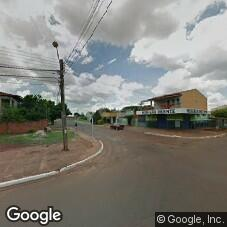

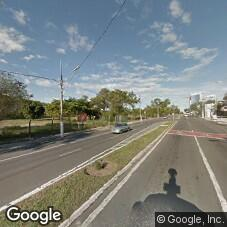

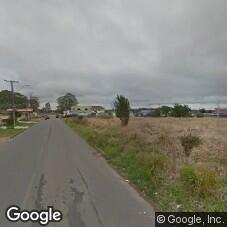

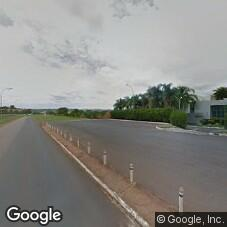

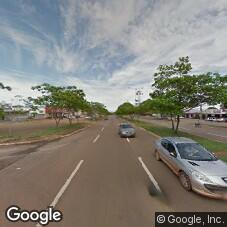

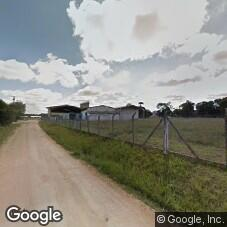

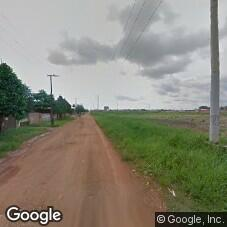

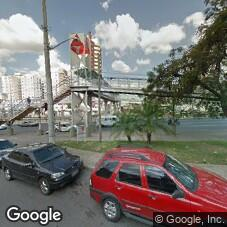

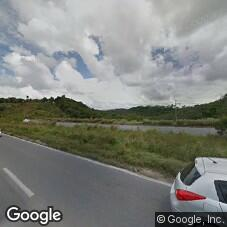

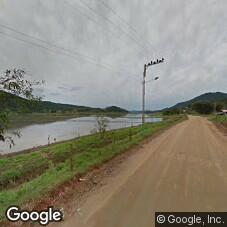

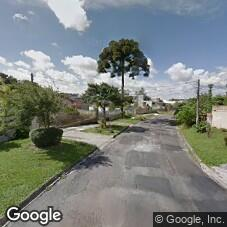

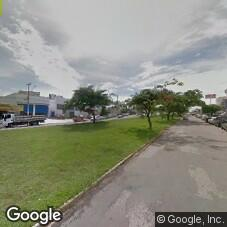

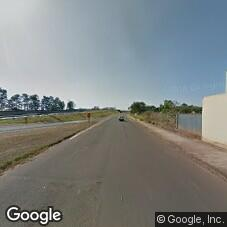

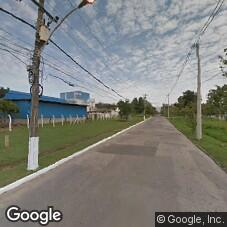

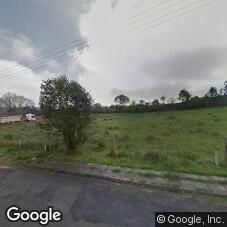

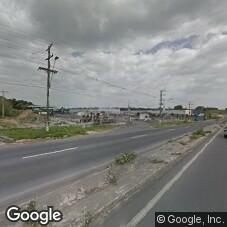

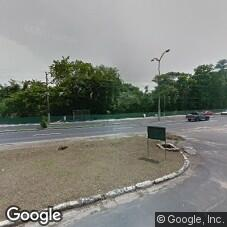

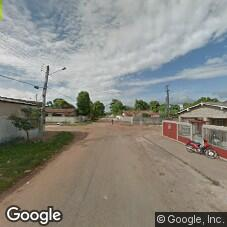

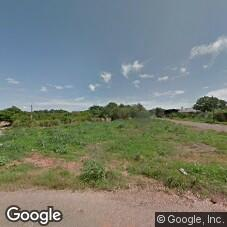

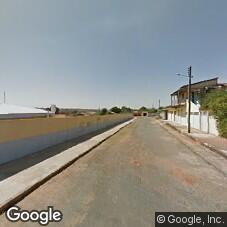

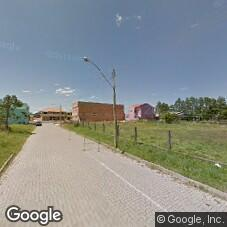

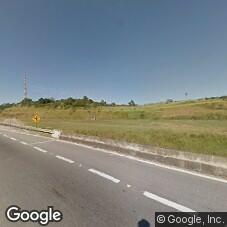

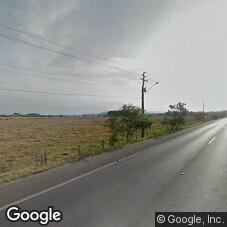

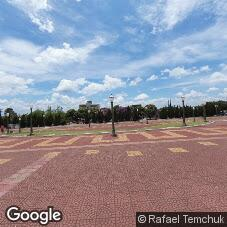

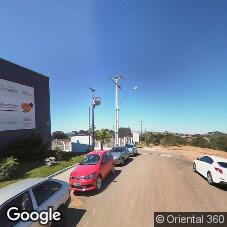

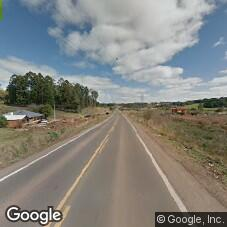

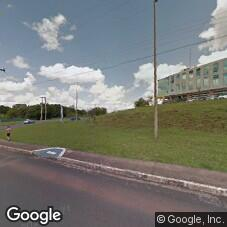

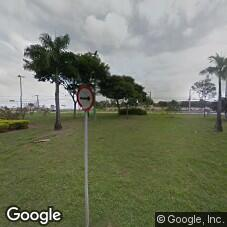

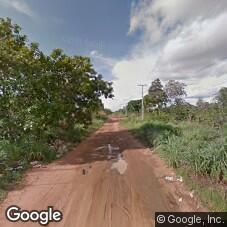

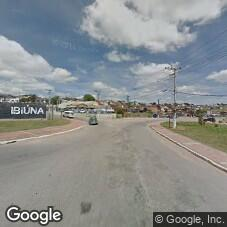

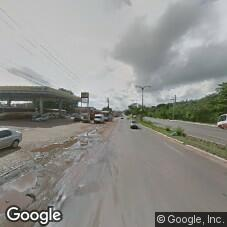

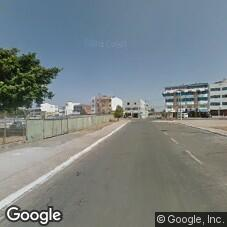

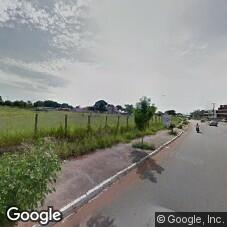

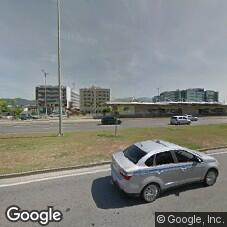

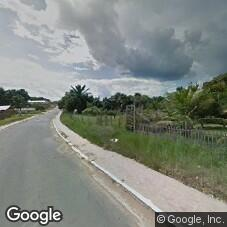

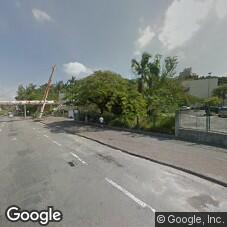

In [16]:
#for r in list(resultado[resultado['cluster'] == 0]['imagem']):
#Image(filename='Imagens/'+list(resultado[resultado['cluster'] == 0]['imagem'])[0])
#Image(filename='Imagens/'+list(resultado[resultado['cluster'] == 0]['imagem'])[1])

for r in list(resultado[resultado['cluster'] == 0]['imagem']):
    display(Image(filename='Imagens/'+r, retina=True))


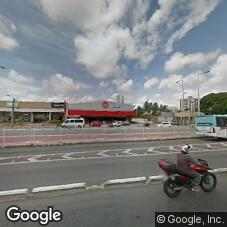

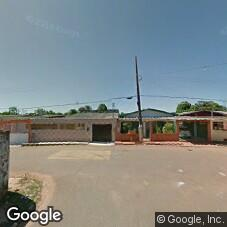

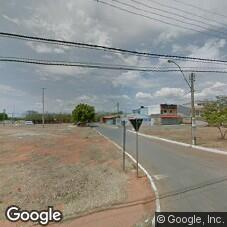

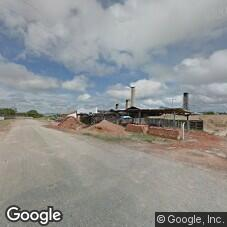

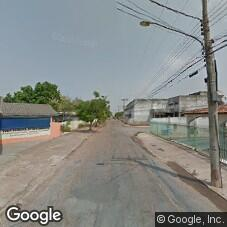

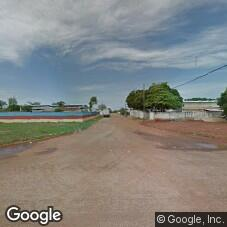

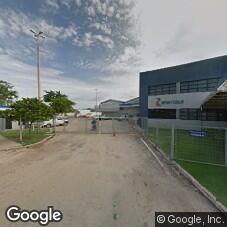

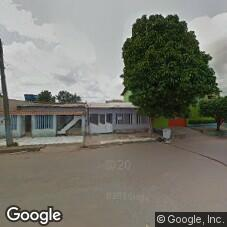

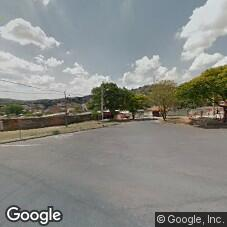

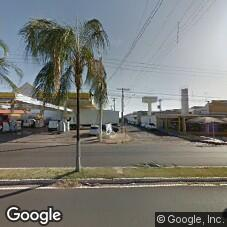

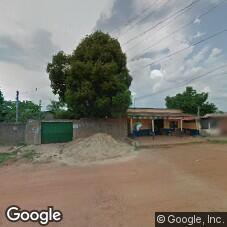

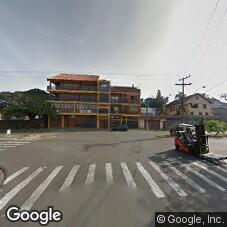

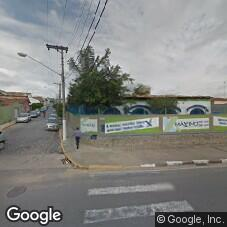

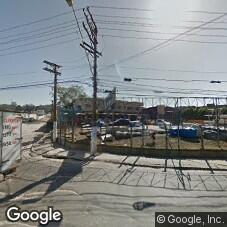

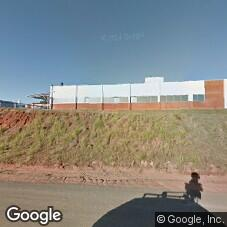

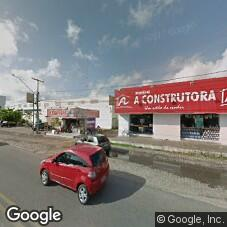

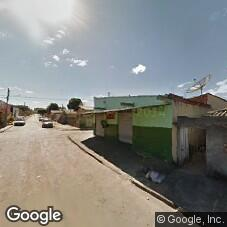

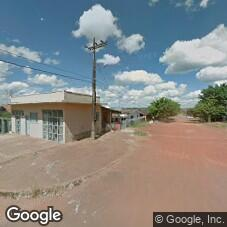

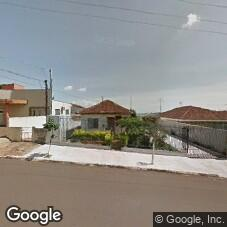

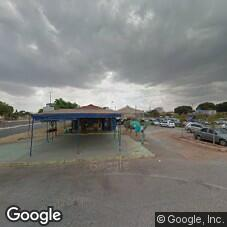

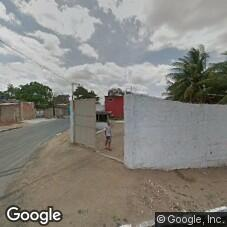

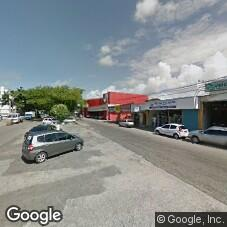

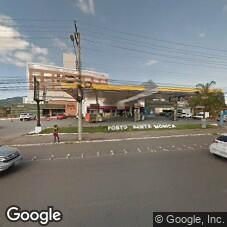

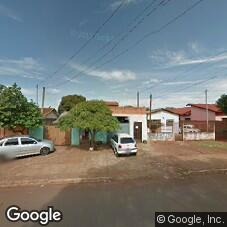

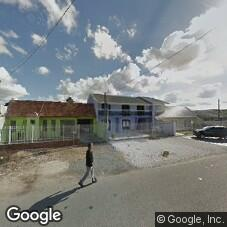

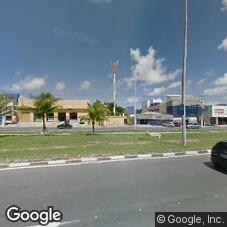

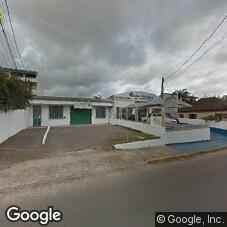

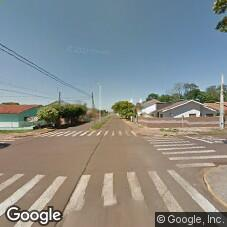

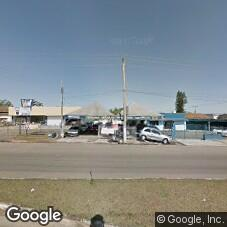

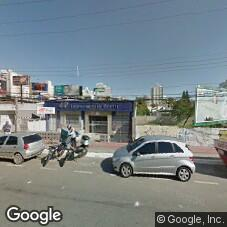

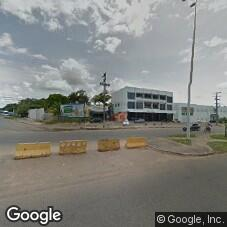

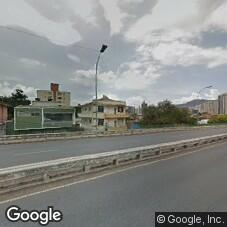

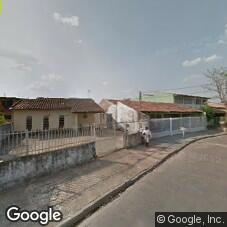

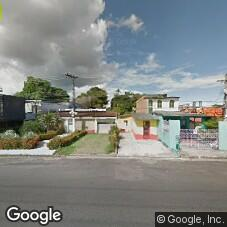

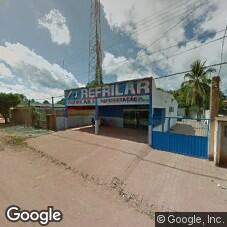

In [17]:
for r in list(resultado[resultado['cluster'] == 1]['imagem']):
    display(Image(filename='Imagens/'+r, retina=True))

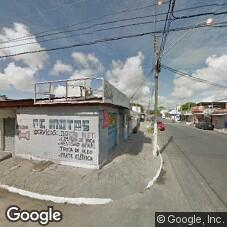

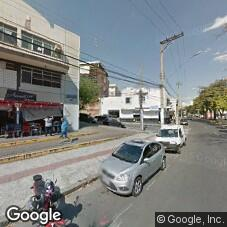

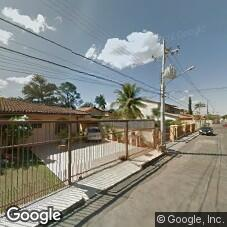

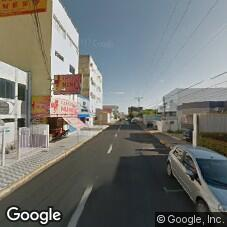

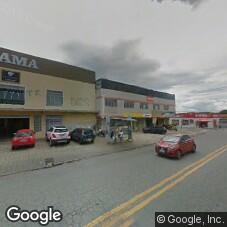

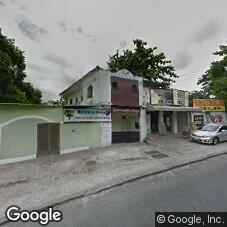

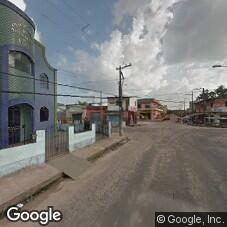

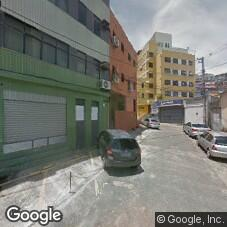

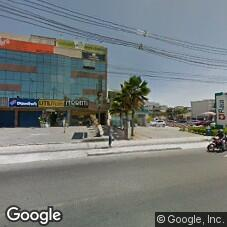

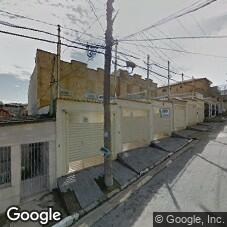

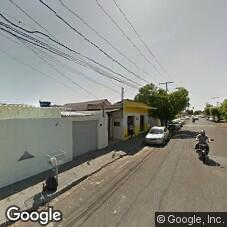

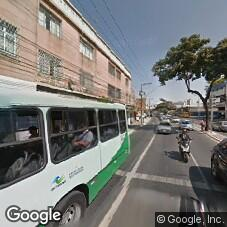

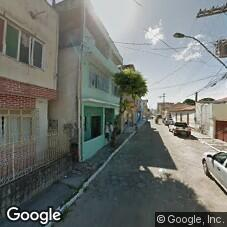

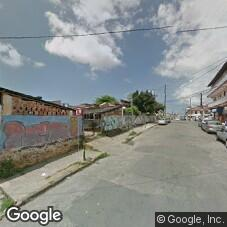

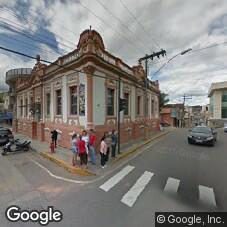

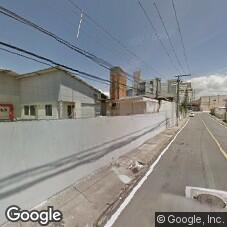

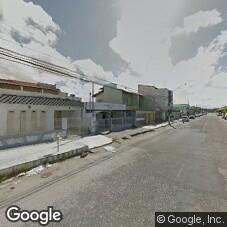

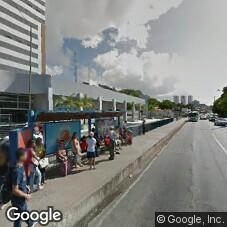

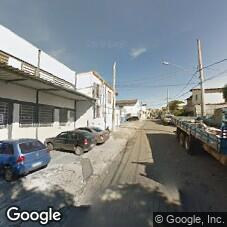

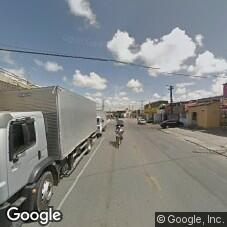

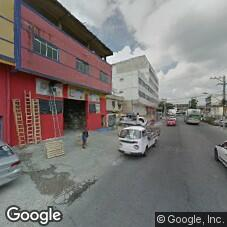

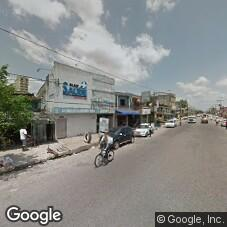

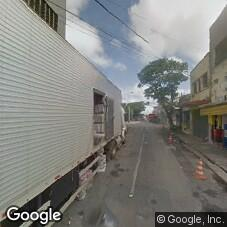

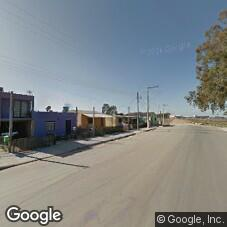

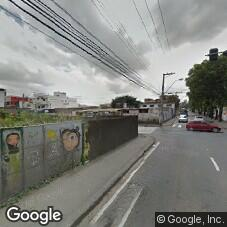

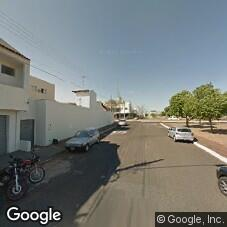

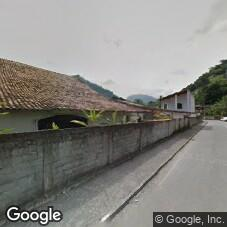

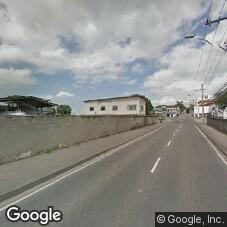

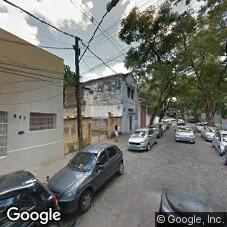

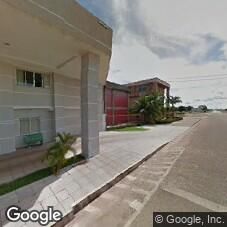

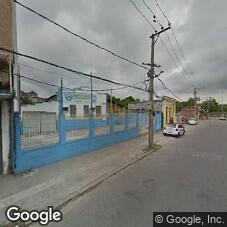

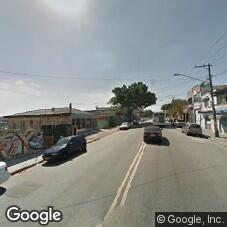

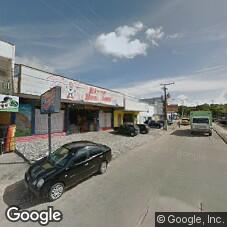

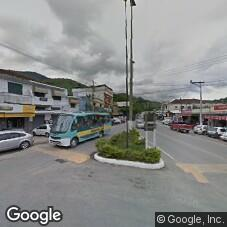

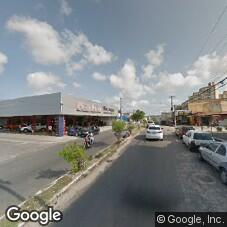

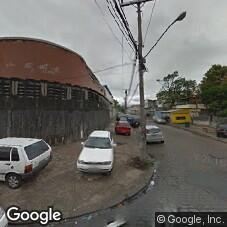

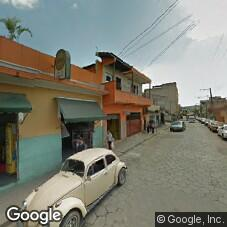

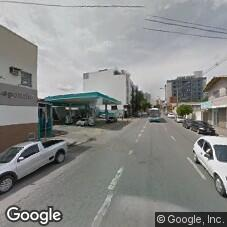

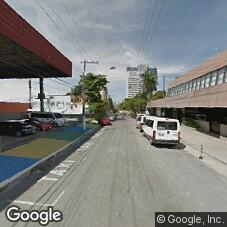

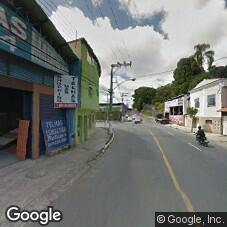

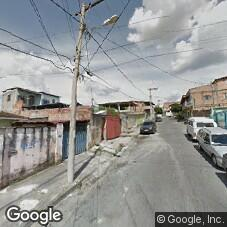

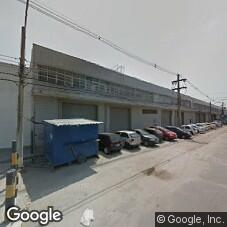

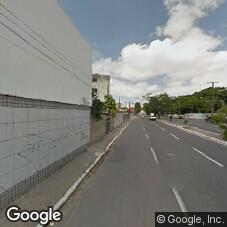

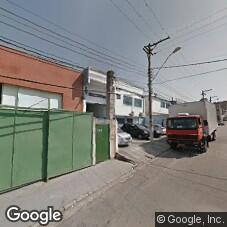

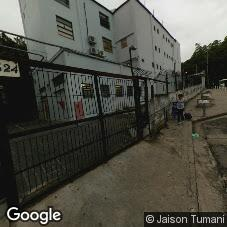

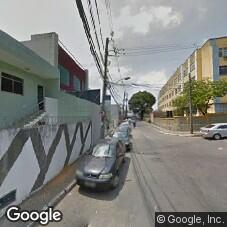

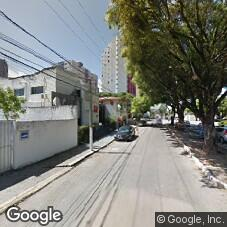

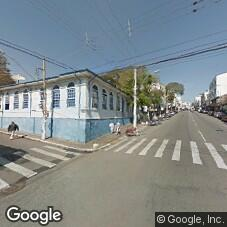

In [18]:
for r in list(resultado[resultado['cluster'] == 2]['imagem']):
    display(Image(filename='Imagens/'+r, retina=True))

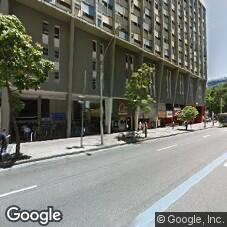

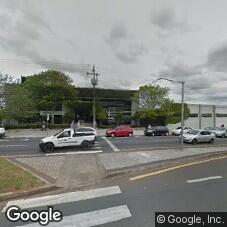

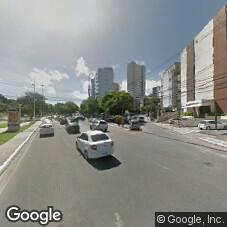

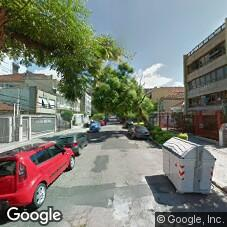

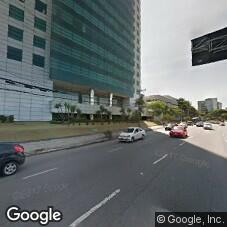

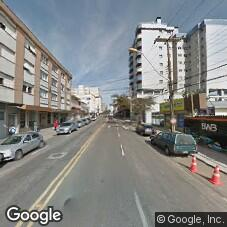

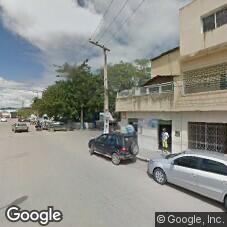

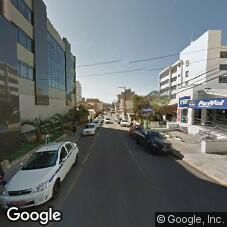

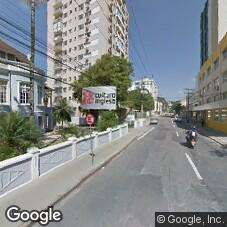

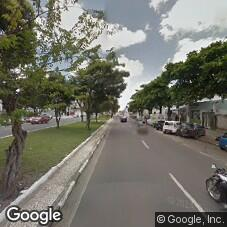

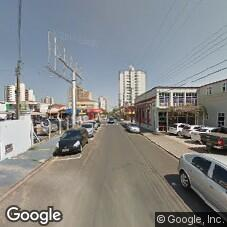

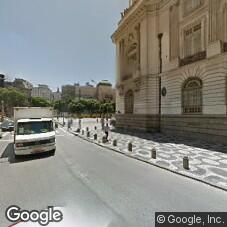

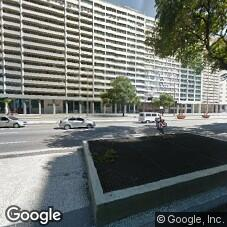

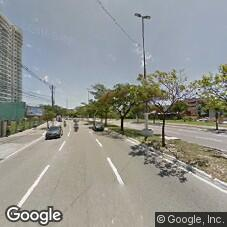

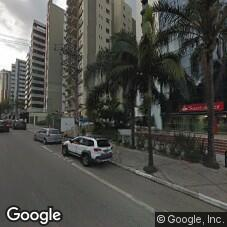

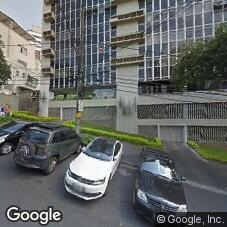

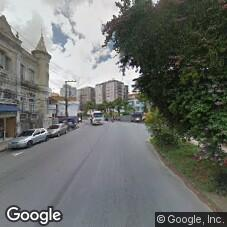

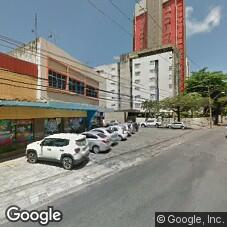

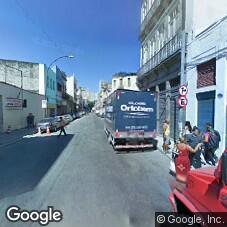

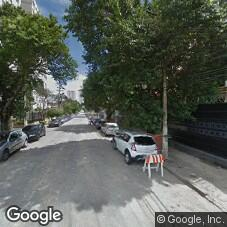

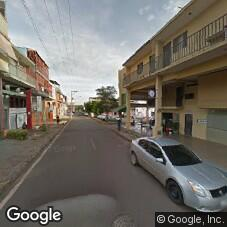

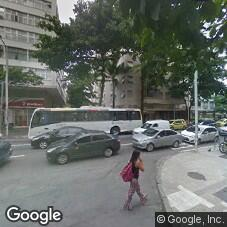

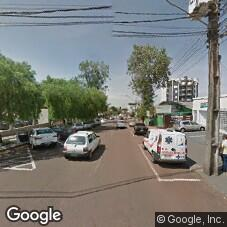

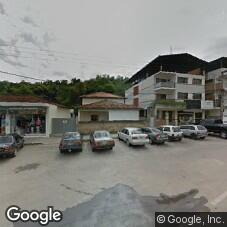

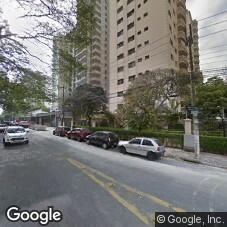

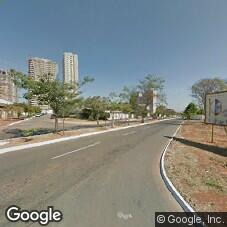

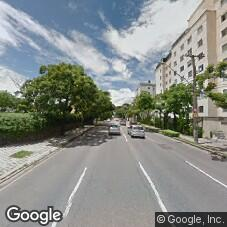

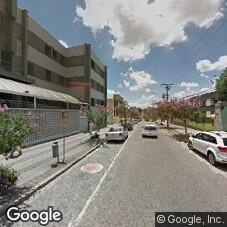

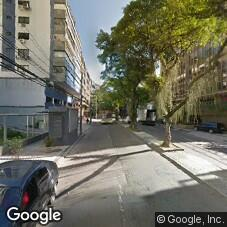

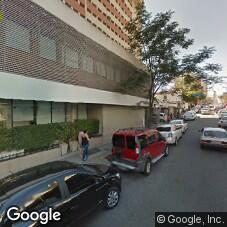

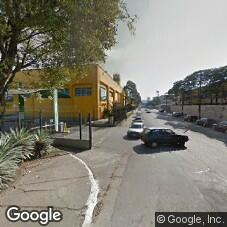

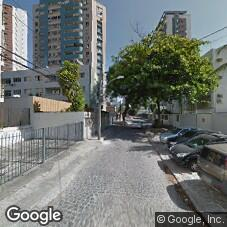

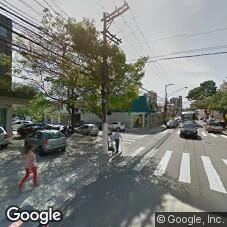

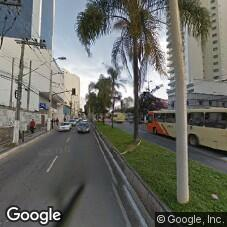

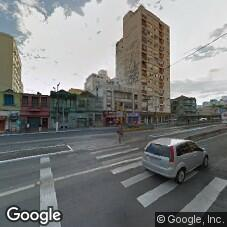

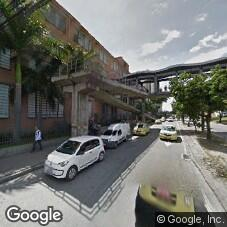

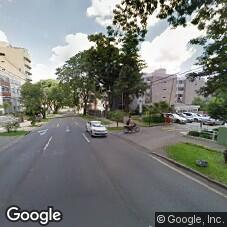

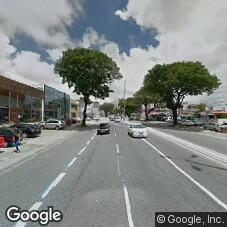

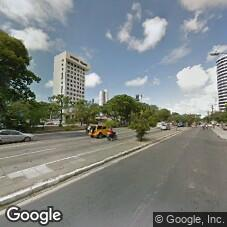

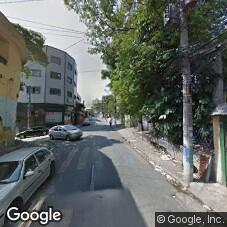

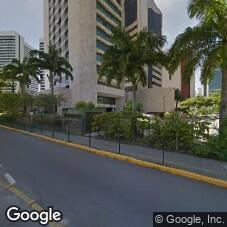

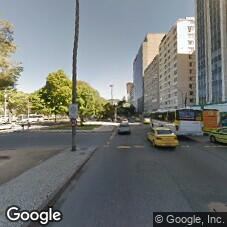

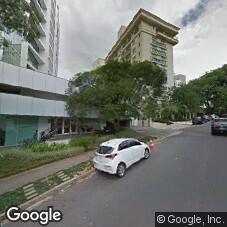

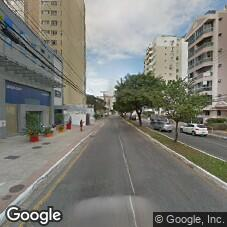

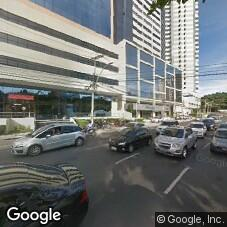

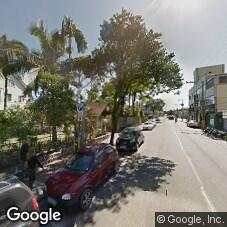

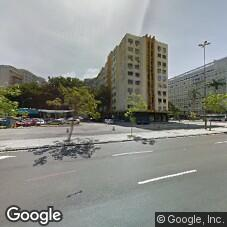

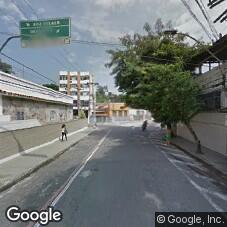

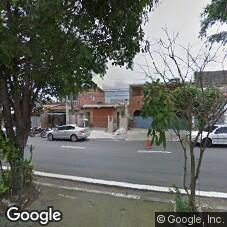

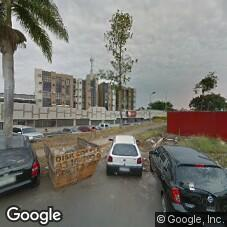

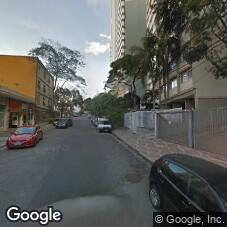

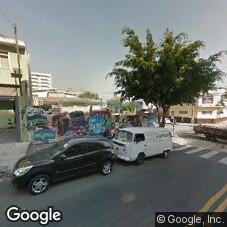

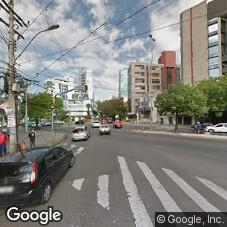

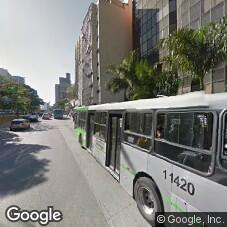

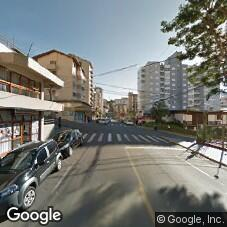

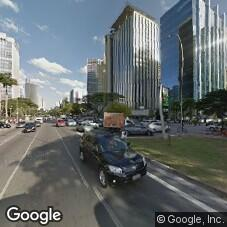

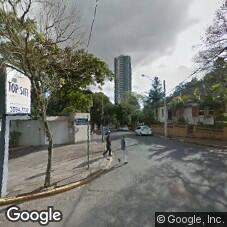

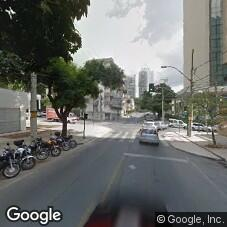

In [19]:
for r in list(resultado[resultado['cluster'] == 3]['imagem']):
    display(Image(filename='Imagens/'+r, retina=True))

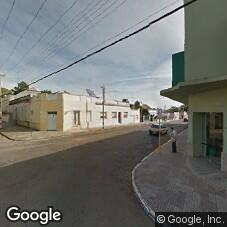

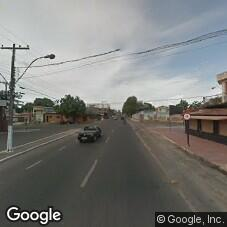

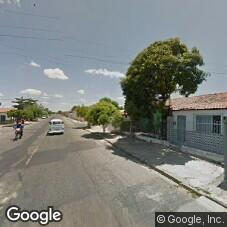

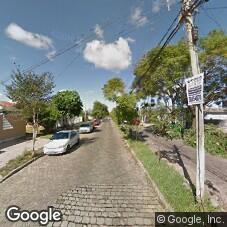

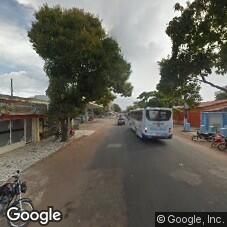

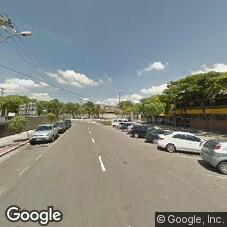

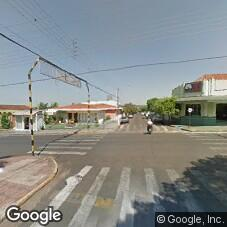

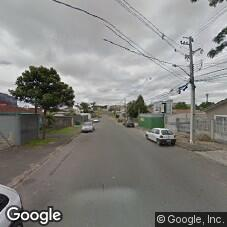

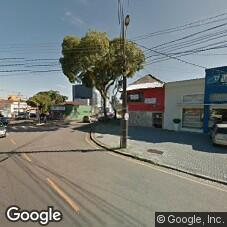

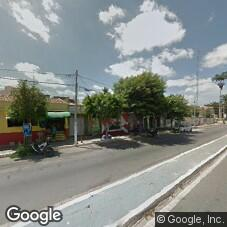

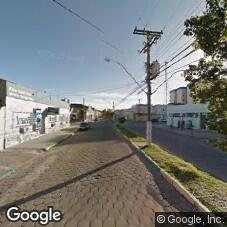

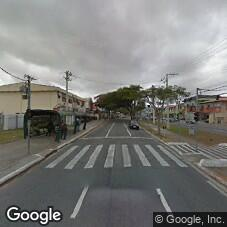

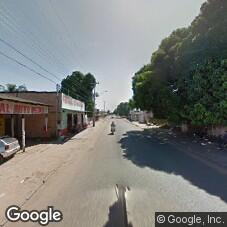

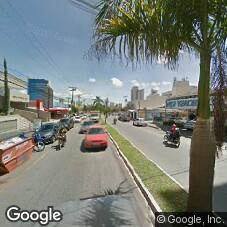

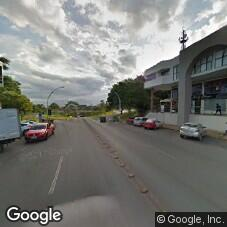

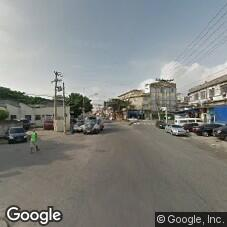

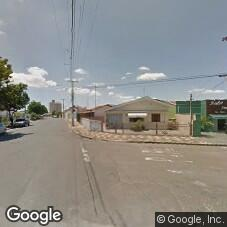

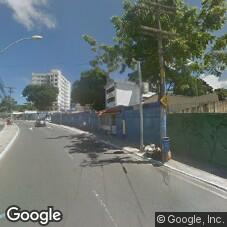

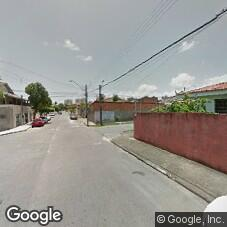

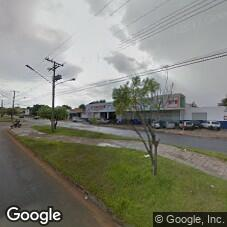

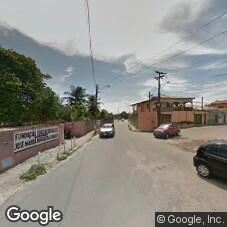

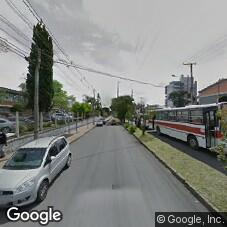

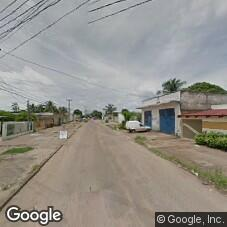

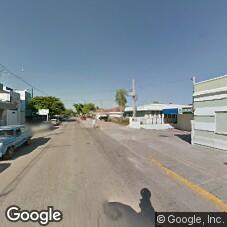

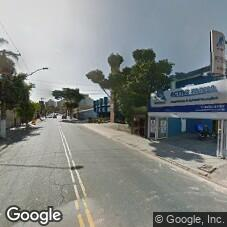

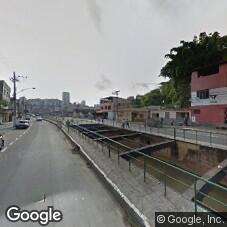

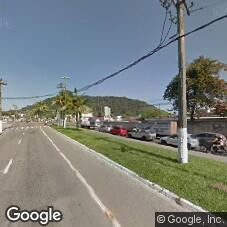

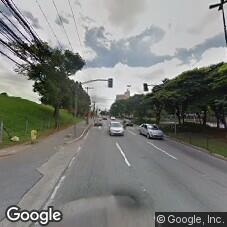

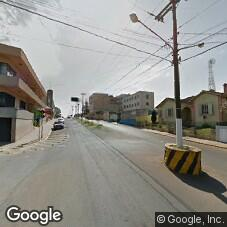

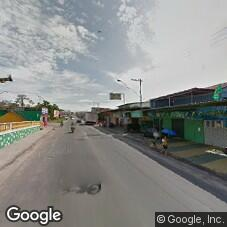

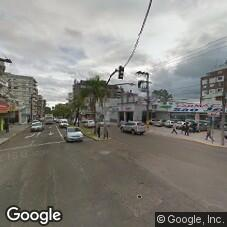

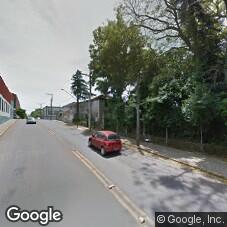

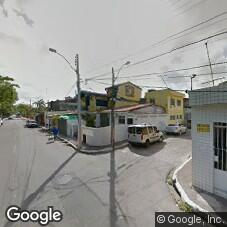

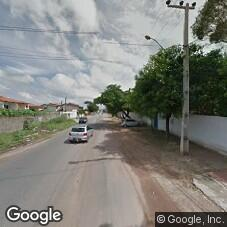

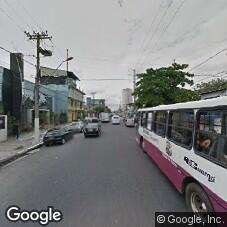

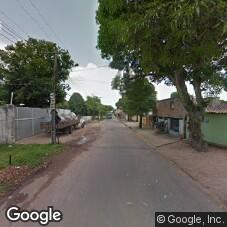

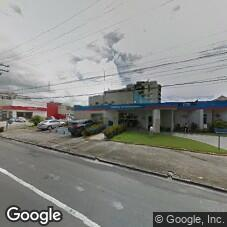

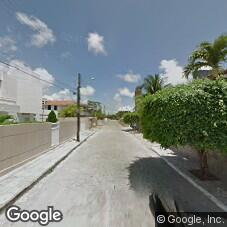

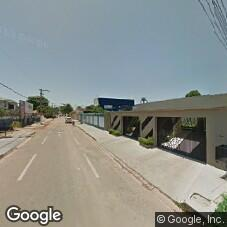

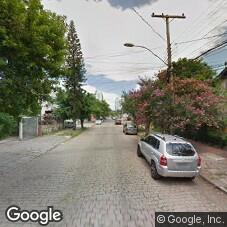

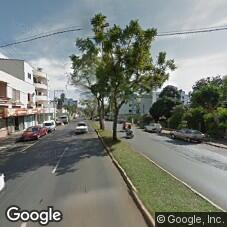

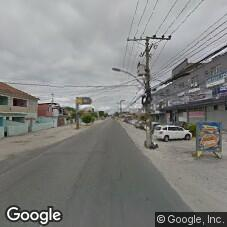

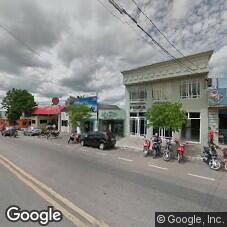

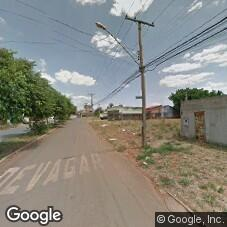

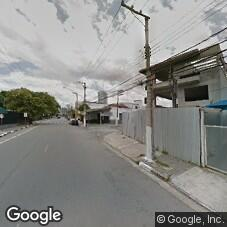

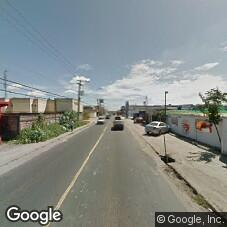

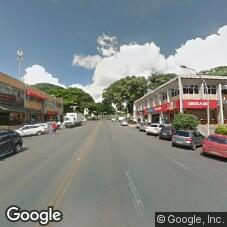

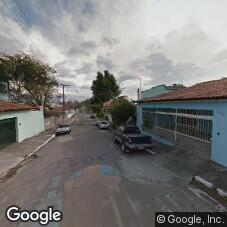

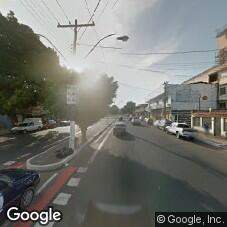

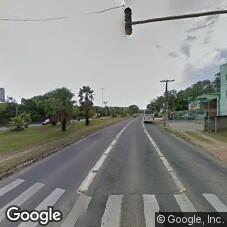

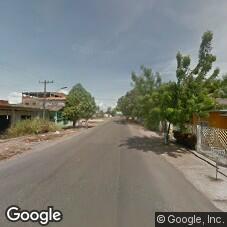

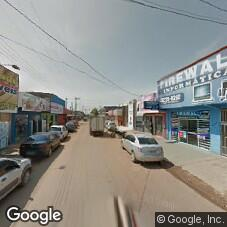

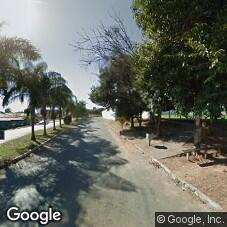

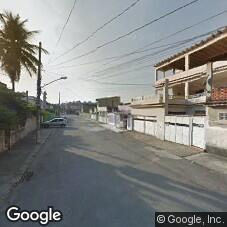

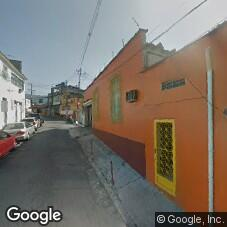

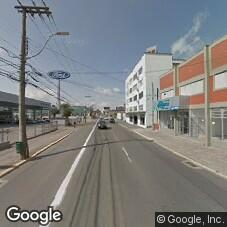

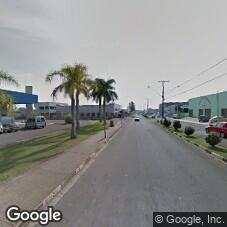

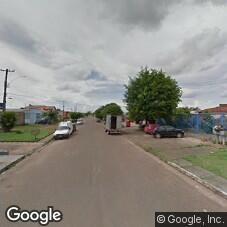

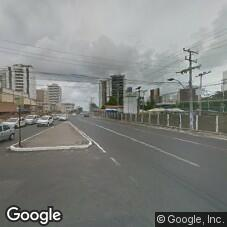

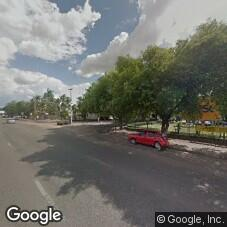

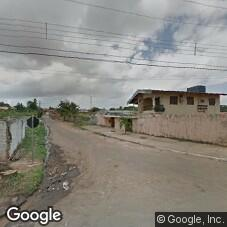

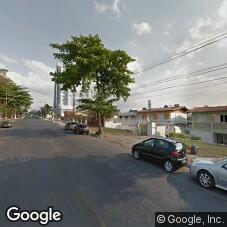

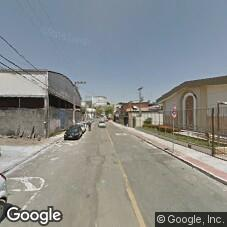

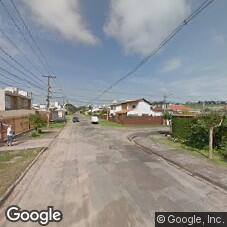

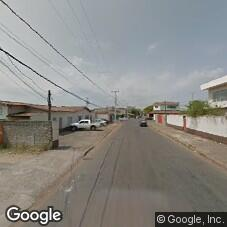

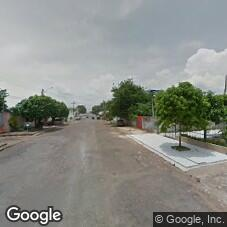

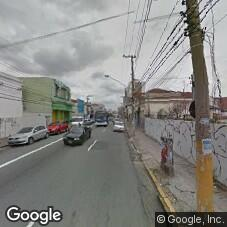

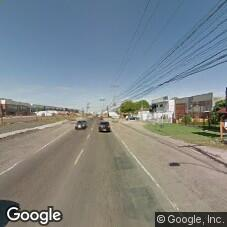

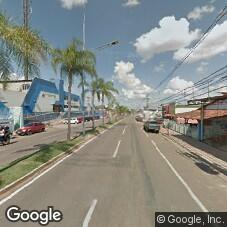

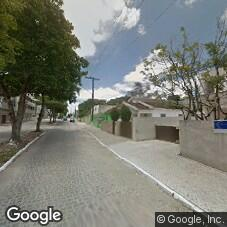

In [20]:
for r in list(resultado[resultado['cluster'] == 4]['imagem']):
    display(Image(filename='Imagens/'+r, retina=True))

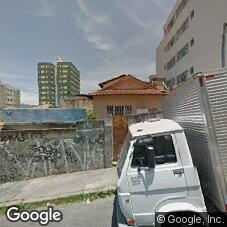

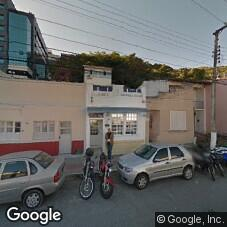

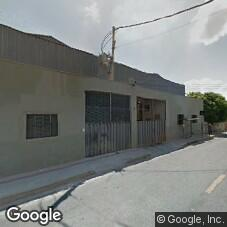

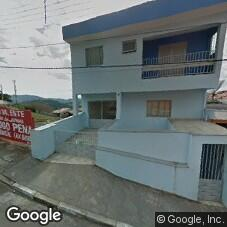

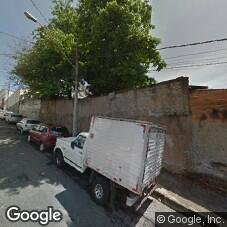

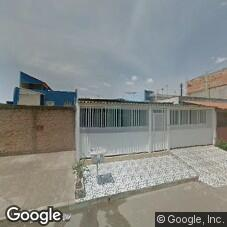

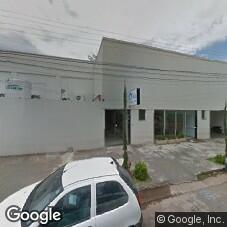

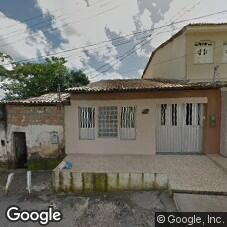

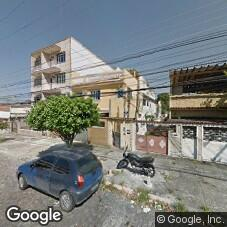

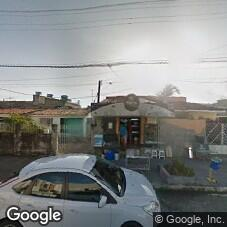

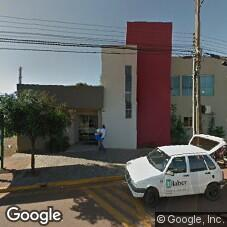

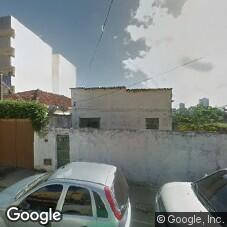

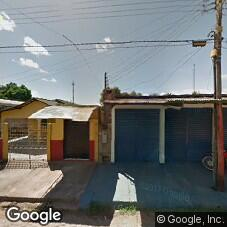

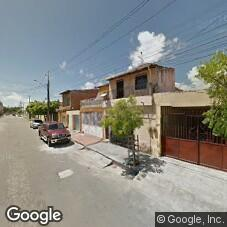

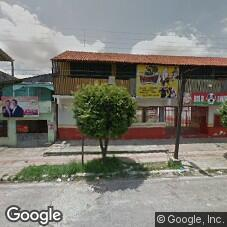

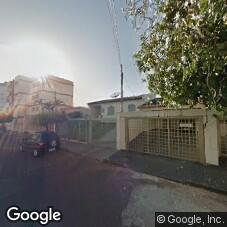

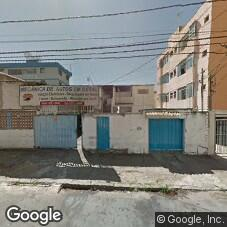

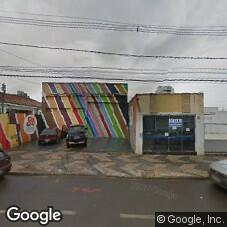

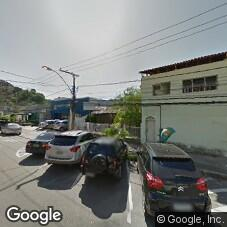

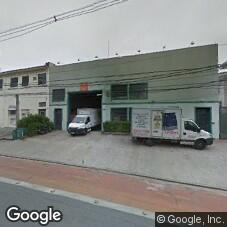

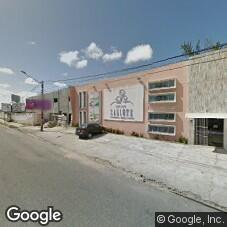

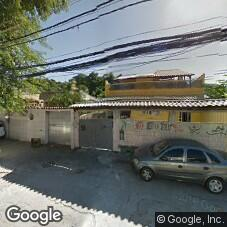

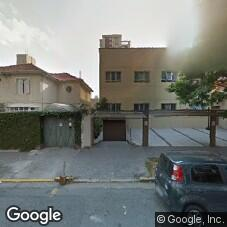

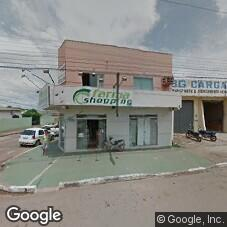

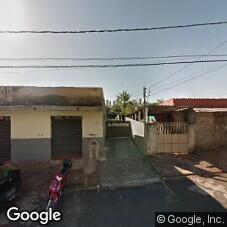

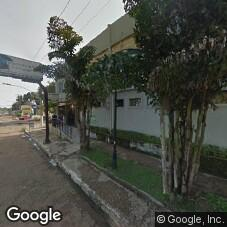

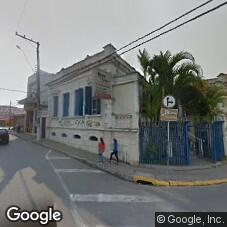

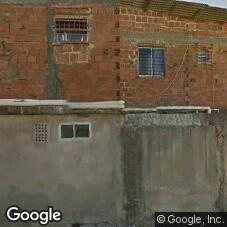

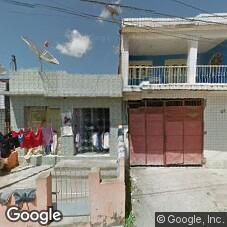

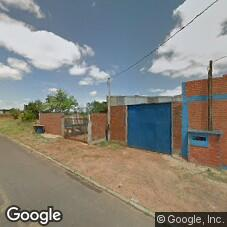

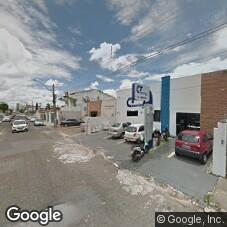

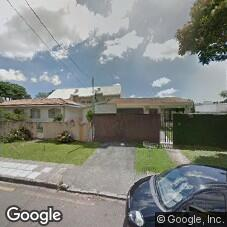

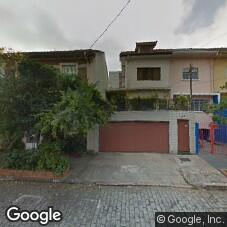

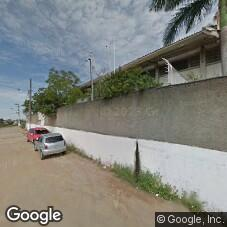

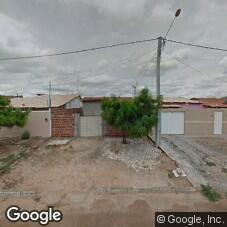

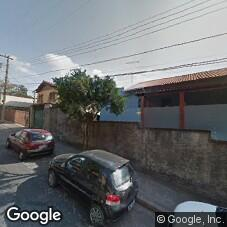

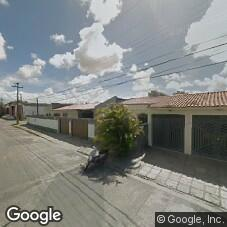

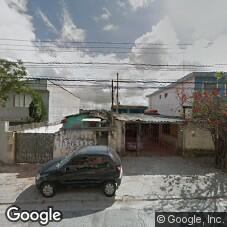

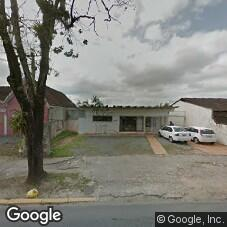

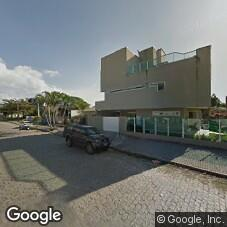

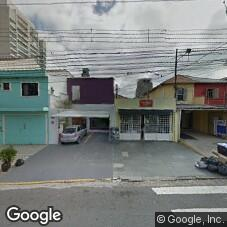

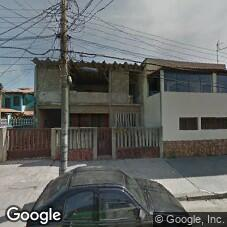

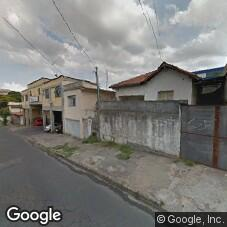

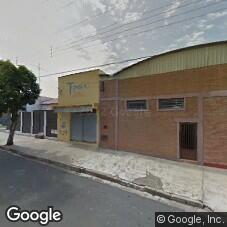

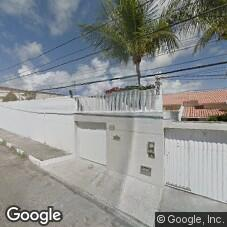

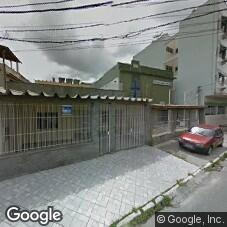

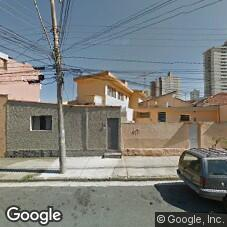

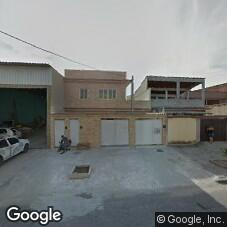

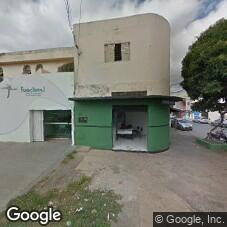

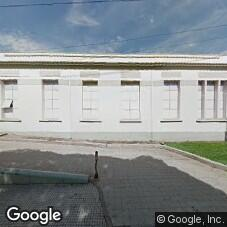

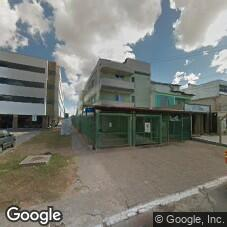

In [21]:
for r in list(resultado[resultado['cluster'] == 5]['imagem']):
    display(Image(filename='Imagens/'+r, retina=True))

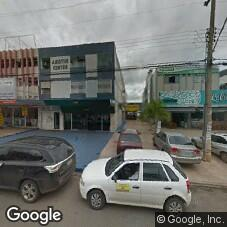

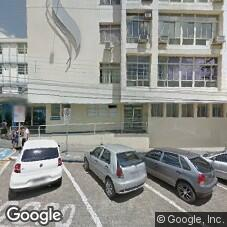

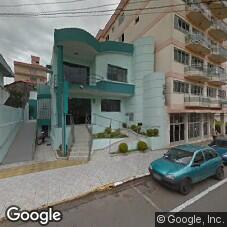

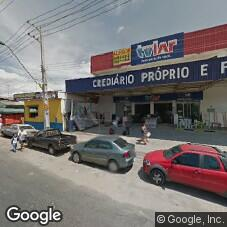

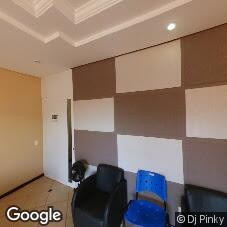

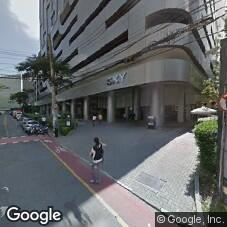

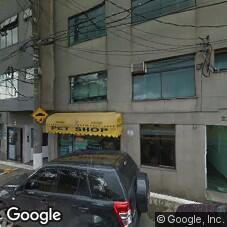

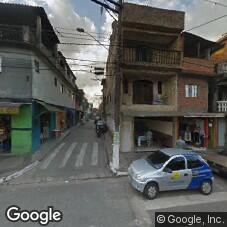

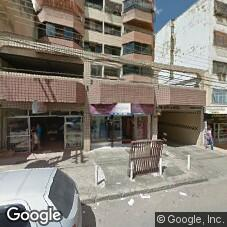

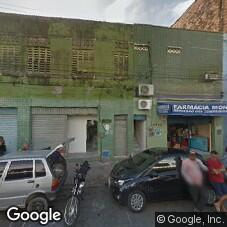

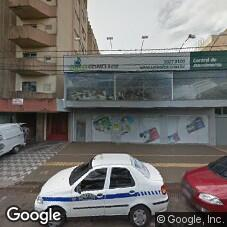

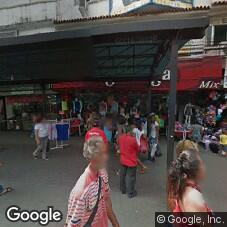

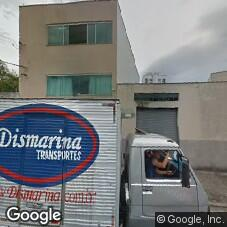

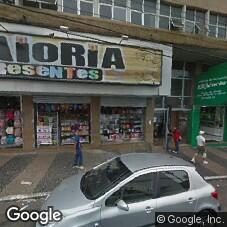

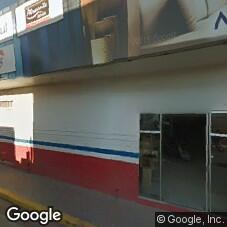

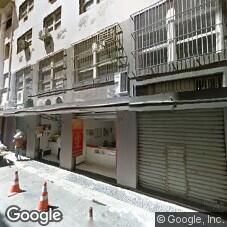

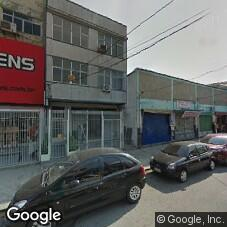

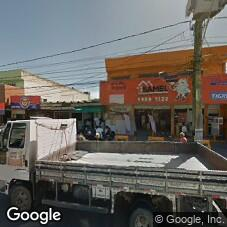

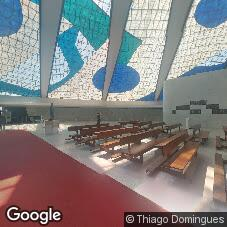

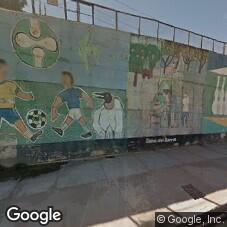

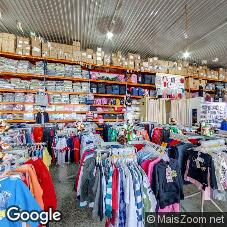

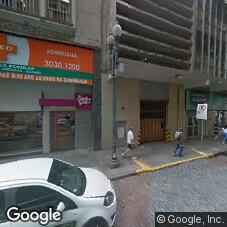

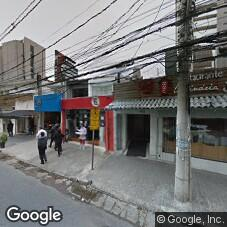

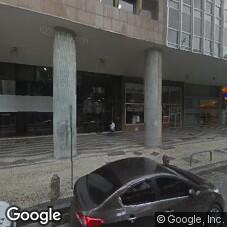

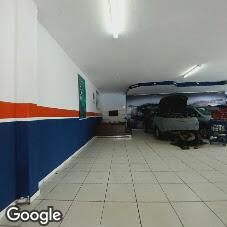

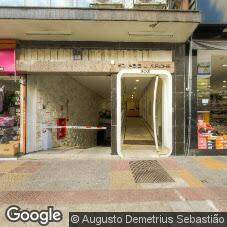

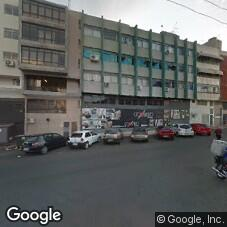

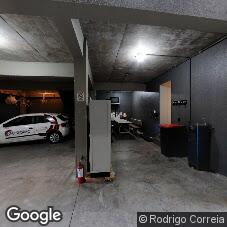

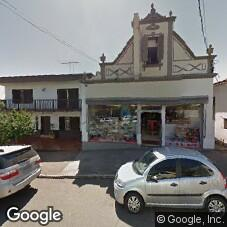

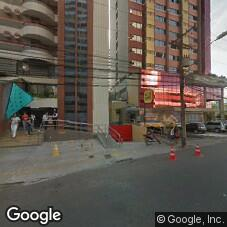

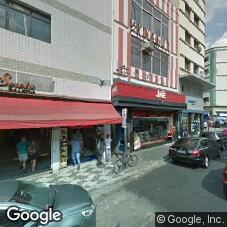

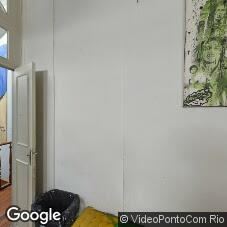

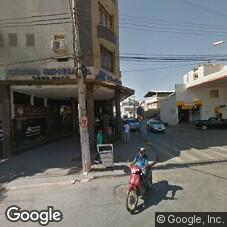

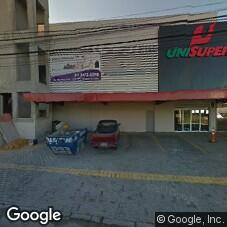

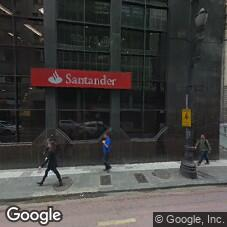

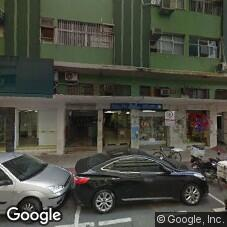

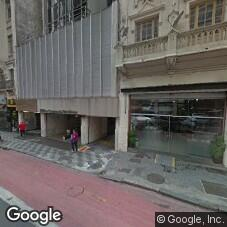

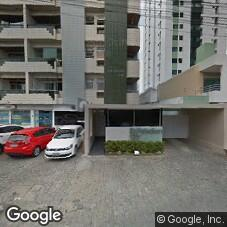

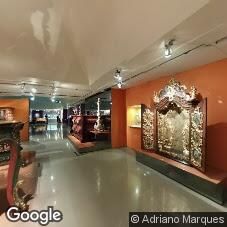

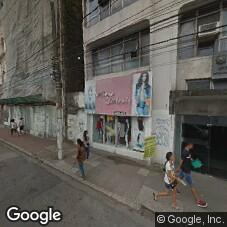

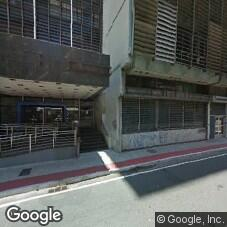

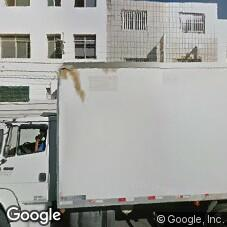

In [22]:
for r in list(resultado[resultado['cluster'] == 6]['imagem']):
    display(Image(filename='Imagens/'+r, retina=True))

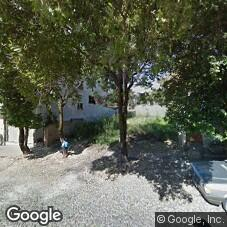

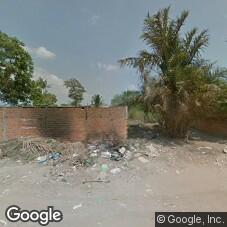

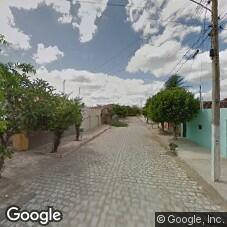

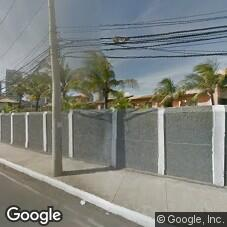

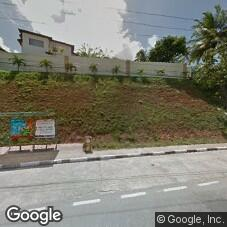

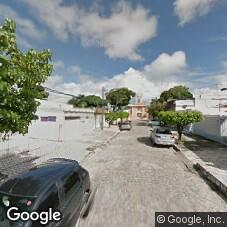

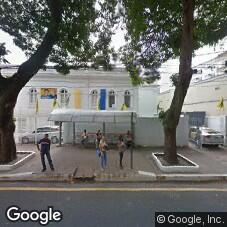

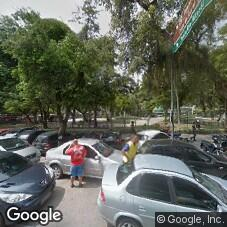

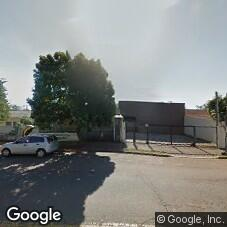

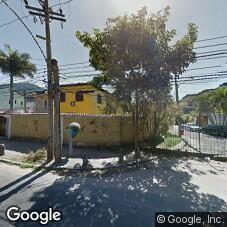

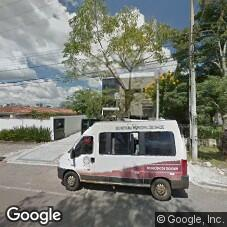

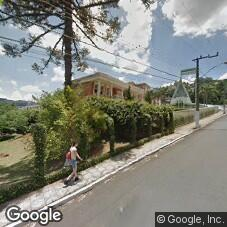

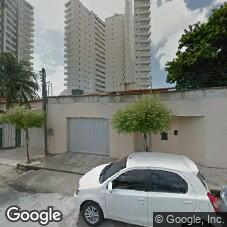

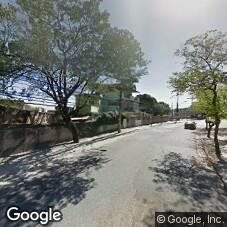

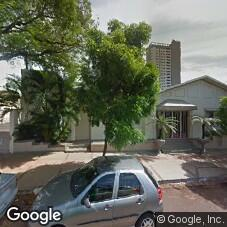

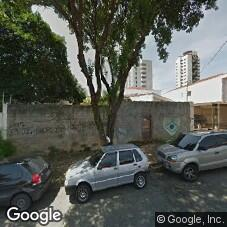

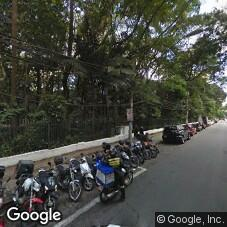

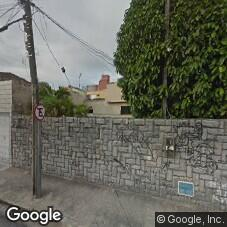

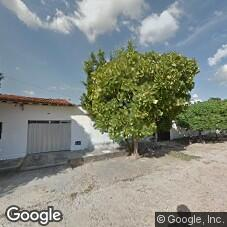

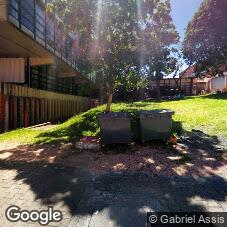

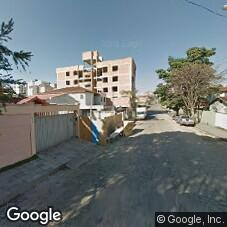

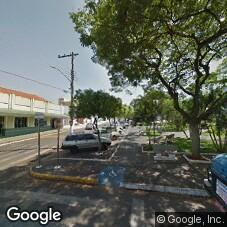

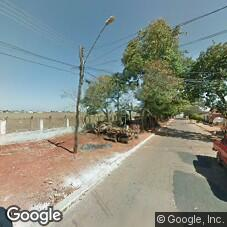

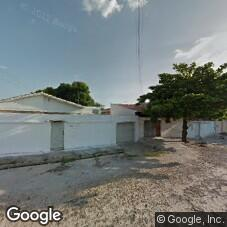

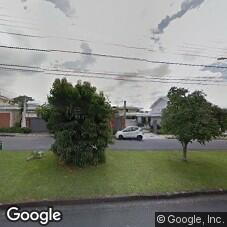

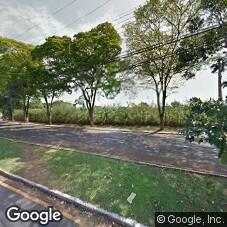

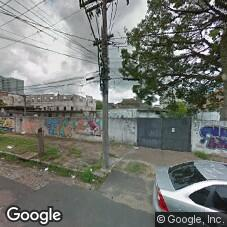

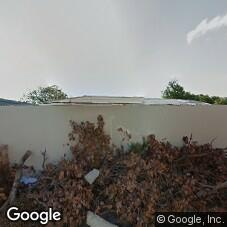

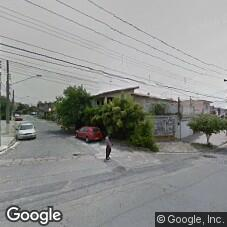

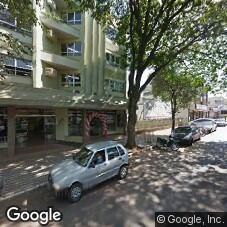

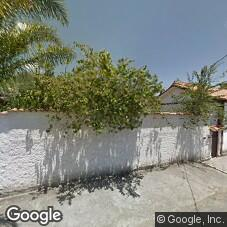

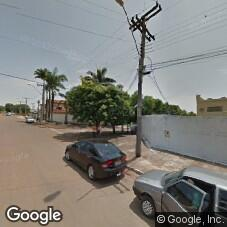

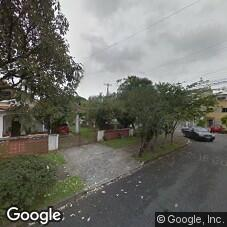

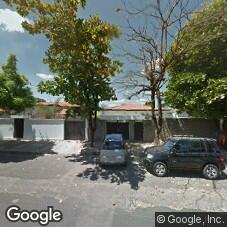

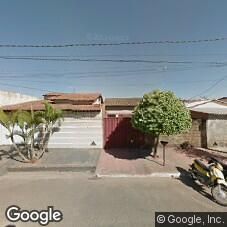

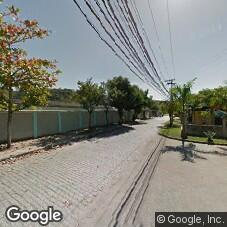

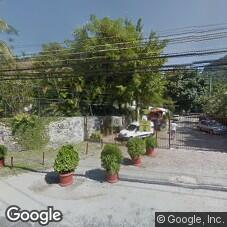

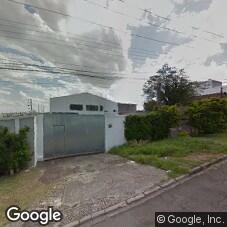

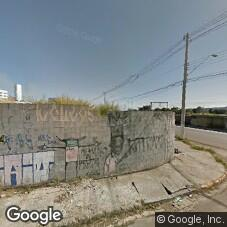

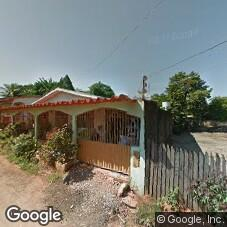

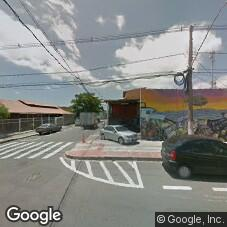

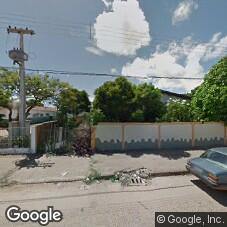

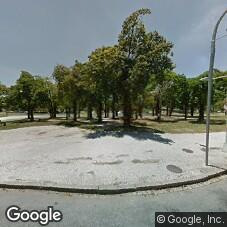

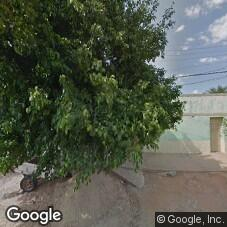

In [23]:
# Árvores...
for r in list(resultado[resultado['cluster'] == 7]['imagem']):
    display(Image(filename='Imagens/'+r, retina=True))

[-5270856.52734375, -4991365.212890625, -4829306.3369140625]


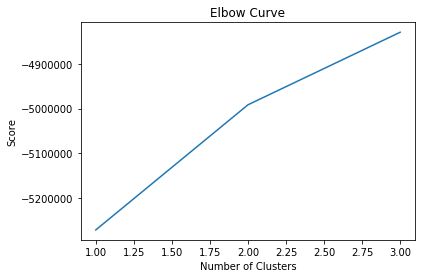

In [24]:
import pylab as pl
Nc = range(1,4)
#kmeans = [KMeans(random_state=0, n_clusters=i).fit(reshaped_X) for i in Nc]
#print(kmeans)
#score = [kmeans[i].score(reshaped_X) for i in range(len(kmeans))]

def kmeans_score(n_clusters):
    return KMeans(random_state=0, n_clusters=n_clusters).fit(reshaped_X).score(reshaped_X)

score  = [KMeans(random_state=0, n_clusters=i).fit(reshaped_X).score(reshaped_X) for i in Nc]

print(score)
pl.plot(Nc,score)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

In [25]:
from multiprocessing import Pool

Nc = range(1,101)
pool = Pool(25)

score1 = pool.map(kmeans_score, [
    1,
    2,
    3,
    4,
    5,
    6,
    7,
    8,
    9,
    10,
    11,
    12,
    13,
    14,
    15,
    16,
    17,
    18,
    19,
    20,
    21,
    22,
    23,
    24,
    25])

In [ ]:
pool = Pool(25)

score2 = pool.map(kmeans_score, [
    26,
    27,
    28,
    29,
    30,
    31,
    32,
    33,
    34,
    35,
    36,
    37,
    38,
    39,
    40,
    41,
    42,
    43,
    44,
    45,
    46,
    47,
    48,
    49,
    50])

In [ ]:
pool = Pool(25)

score3 = pool.map(kmeans_score, [    
    51,
    52,
    53,
    54,
    55,
    56,
    57,
    58,
    59,
    60,
    61,
    62,
    63,
    64,
    65,
    66,
    67,
    68,
    69,
    70,
    71,
    72,
    73,
    74,
    75])

In [ ]:
pool = Pool(25)

score4 = pool.map(kmeans_score, [   
    76,
    77,
    78,
    79,
    80,
    81,
    82,
    83,
    84,
    85,
    86,
    87,
    88,
    89,
    90,
    91,
    92,
    93,
    94,
    95,
    96,
    97,
    98,
    99,
    100
])